In [80]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import sys
sys.path.append('../AJA')
import AJA as aja

In [100]:
# Data recovery
df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

# Feature extraction

from sklearn.preprocessing import StandardScaler

# Node

scaler = StandardScaler()
# Sentence length normalized
df_train_nodes['sentence_length'] = df_train_nodes['text'].apply(lambda s: len(s.split()))
df_train_nodes['sentence_length'] = scaler.fit_transform(df_train_nodes['sentence_length'].values.reshape(-1, 1))
df_test_nodes['sentence_length'] = df_test_nodes['text'].apply(lambda s: len(s.split()))
df_test_nodes['sentence_length'] = scaler.transform(df_test_nodes['sentence_length'].values.reshape(-1, 1))

df_train_nodes['nb_occurences'] = df_train_nodes['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
df_train_nodes['nb_occurences'] = scaler.fit_transform(df_train_nodes['nb_occurences'].values.reshape(-1, 1))
df_test_nodes['nb_occurences'] = df_test_nodes['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
df_test_nodes['nb_occurences'] = scaler.transform(df_test_nodes['nb_occurences'].values.reshape(-1, 1))


df_train_nodes['nb_words_more_7'] = df_train_nodes['text'].apply(lambda x: sum(len(mot) > 7 and mot.lower() != '<vocalsound>' for mot in x.split()))
df_train_nodes['nb_words_more_7'] = scaler.fit_transform(df_train_nodes['nb_words_more_7'].values.reshape(-1, 1))
df_test_nodes['nb_words_more_7'] = df_test_nodes['text'].apply(lambda x: sum(len(mot) > 7 and mot.lower() != '<vocalsound>' for mot in x.split()))
df_test_nodes['nb_words_more_7'] = scaler.transform(df_test_nodes['nb_words_more_7'].values.reshape(-1, 1))


# Speaker hot-one encoding
one_hot_encoded = pd.get_dummies(df_train_nodes['speaker_int'], prefix='speaker', dtype=int)
df_train_nodes = df_train_nodes.drop('speaker_int', axis=1)
df_train_nodes = df_train_nodes.drop('speaker_text', axis=1)
df_train_nodes = pd.concat([df_train_nodes, one_hot_encoded], axis=1)

one_hot_encoded = pd.get_dummies(df_test_nodes['speaker_int'], prefix='speaker', dtype=int)
df_test_nodes = df_test_nodes.drop('speaker_int', axis=1)
df_test_nodes = df_test_nodes.drop('speaker_text', axis=1)
df_test_nodes = pd.concat([df_test_nodes, one_hot_encoded], axis=1)

# TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train_nodes['text'])
df_train_nodes['tfidf_sum'] = tfidf_matrix.sum(axis=1)
df_train_nodes['tfidf_max'] = tfidf_matrix.max(axis=1).toarray().flatten()

tfidf_matrix_test = tfidf_vectorizer.fit_transform(df_test_nodes['text'])
df_test_nodes['tfidf_sum'] = tfidf_matrix_test.sum(axis=1)
df_test_nodes['tfidf_max'] = tfidf_matrix_test.max(axis=1).toarray().flatten()

df_train_nodes['tfidf_sum'] = scaler.fit_transform(df_train_nodes['tfidf_sum'].values.reshape(-1,1))
df_test_nodes['tfidf_sum'] = scaler.transform(df_test_nodes['tfidf_sum'].values.reshape(-1,1))

df_train_nodes['tfidf_max'] = scaler.fit_transform(df_train_nodes['tfidf_max'].values.reshape(-1,1))
df_test_nodes['tfidf_max'] = scaler.transform(df_test_nodes['tfidf_max'].values.reshape(-1,1))

# Edge

new_df = pd.DataFrame({
        'transcription': df_train_edges['transcription'],
        'start': df_train_edges['end'],
        'end': df_train_edges['start'],
        'type_int': 16 + df_train_edges['type_int'],
        'type_text': df_train_edges['type_text'] + "_reverse"
    })
df_train_edges = pd.concat([df_train_edges, new_df], ignore_index=True)

new_df = pd.DataFrame({
        'transcription': df_test_edges['transcription'],
        'start': df_test_edges['end'],
        'end': df_test_edges['start'],
        'type_int': 16 + df_test_edges['type_int'],
        'type_text': df_test_edges['type_text'] + "_reverse"
    })
df_test_edges = pd.concat([df_test_edges, new_df], ignore_index=True)

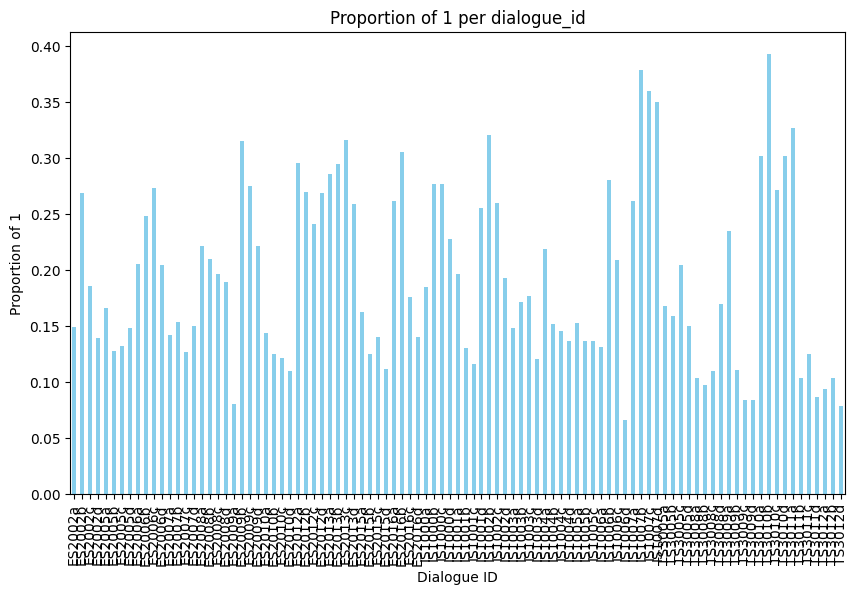

In [83]:
# Group by dialog and calculate the sum of the 'label' column for each group
label_sum_per_dialogue = df_train_nodes.groupby('transcription')['label'].sum()

# Group by 'dialogue_id' and calculate the total number of lines for each group
total_rows_per_dialogue = df_train_nodes.groupby('transcription').size()

# Calculate the proportion by dividing the sum of labels by the total number of lines for each group
proportion_of_1_per_dialogue = label_sum_per_dialogue / total_rows_per_dialogue

proportion_of_1_per_dialogue.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Proportion of 1 per dialogue_id')
plt.xlabel('Dialogue ID')
plt.ylabel('Proportion of 1')
plt.show()

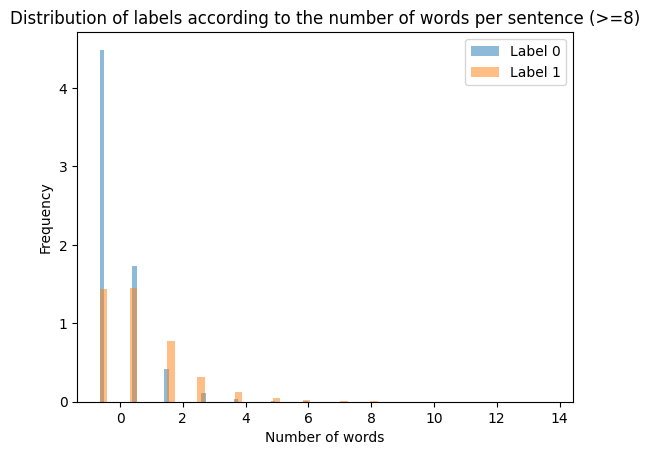

In [72]:
label_0_data = df_train_nodes[df_train_nodes['label'] == 0]['nb_words_more_7']
label_1_data = df_train_nodes[df_train_nodes['label'] == 1]['nb_words_more_7']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0', density=True)
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1', density=True)

plt.xlabel('Number of words')
plt.ylabel('Frequency')

plt.title('Distribution of labels according to the number of words per sentence (>=8)')
plt.legend()
plt.show()

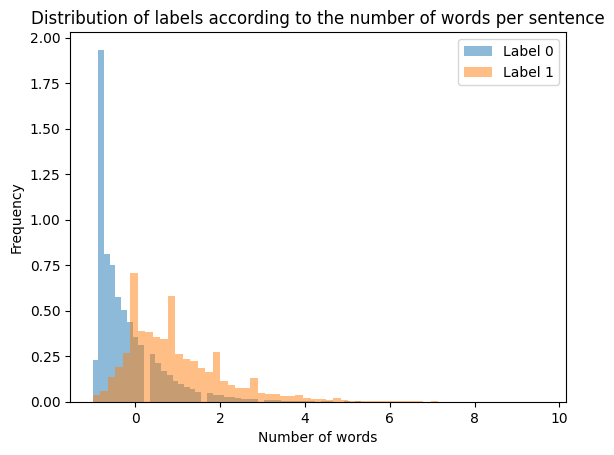

In [73]:
label_0_data = df_train_nodes[df_train_nodes['label'] == 0]['sentence_length']
label_1_data = df_train_nodes[df_train_nodes['label'] == 1]['sentence_length']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0', density=True)
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1', density=True)

plt.xlabel('Number of words')
plt.ylabel('Frequency')


plt.title('Distribution of labels according to the number of words per sentence')
plt.legend()
plt.show()


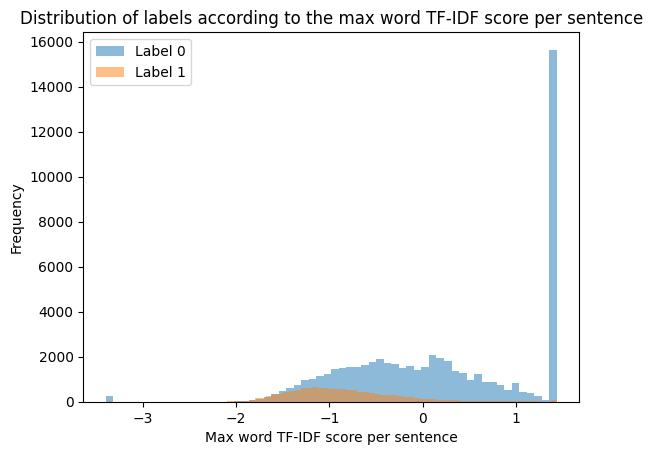

In [74]:
label_0_data = df_train_nodes[df_train_nodes['label'] == 0]['tfidf_max']
label_1_data = df_train_nodes[df_train_nodes['label'] == 1]['tfidf_max']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Max word TF-IDF score per sentence')
plt.ylabel('Frequency')

plt.title('Distribution of labels according to the max word TF-IDF score per sentence')
plt.legend()
plt.show()

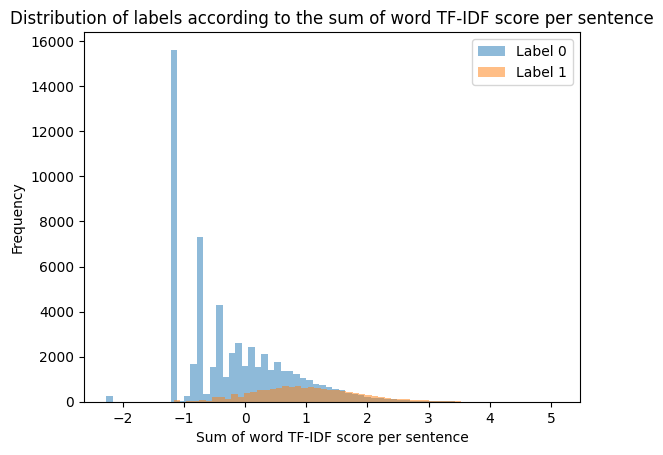

In [75]:
label_0_data = df_train_nodes[df_train_nodes['label'] == 0]['tfidf_sum']
label_1_data = df_train_nodes[df_train_nodes['label'] == 1]['tfidf_sum']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Sum of word TF-IDF score per sentence')
plt.ylabel('Frequency')

plt.title('Distribution of labels according to the sum of word TF-IDF score per sentence')
plt.legend()
plt.show()


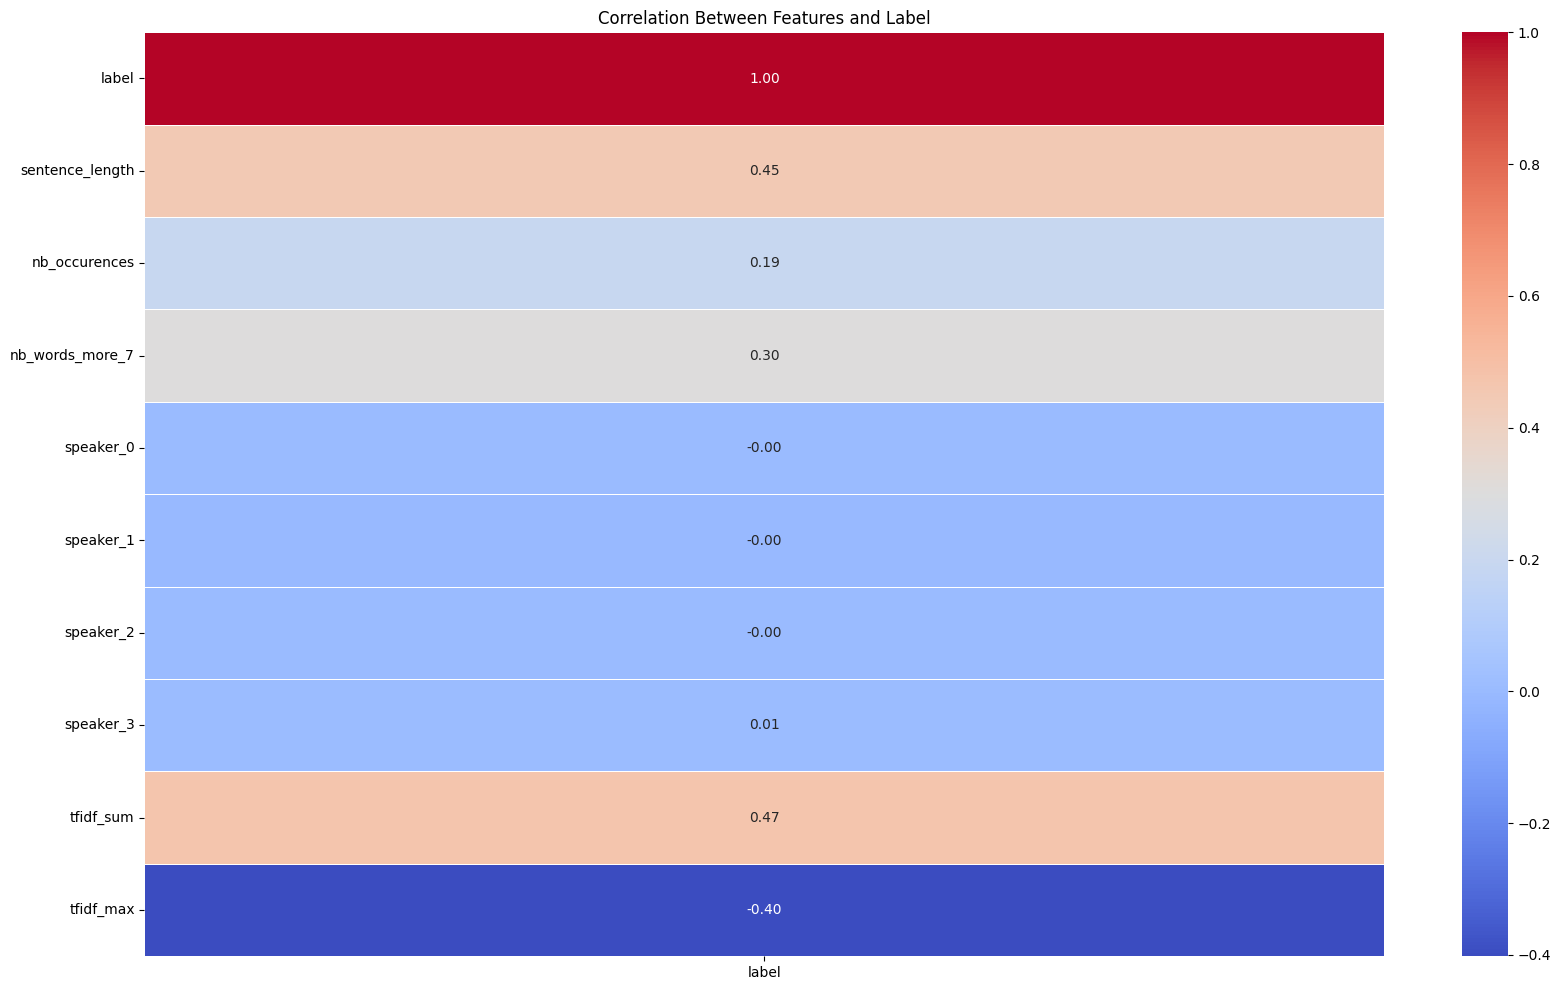

In [112]:
import seaborn as sns

df_features = df_train_nodes[['label','sentence_length', 'nb_occurences', 'nb_words_more_7', 'speaker_0',
       'speaker_1', 'speaker_2', 'speaker_3', 'tfidf_sum', 'tfidf_max']]
numeric_columns = df_features.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix[['label']], annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Between Features and Label')
plt.show()
